# 🎯 Trajectory Optimization

Welcome to the third notebook! Here we'll tackle the core challenge of TrajectoryForge: **finding force field configurations that produce desired trajectories**.

## What You'll Learn

1. **The Inverse Problem**: Why it's hard and how gradients help
2. **Loss Functions**: Different ways to measure trajectory error
3. **Gradient Descent**: Optimizing force field parameters
4. **Challenges**: Local minima, sensitivity, and multiple solutions
5. **Visualization**: Understanding the optimization landscape

## Prerequisites

- Completed Notebooks 01 and 02
- Understanding of gradient descent

Let's solve the inverse problem! 🚀


In [1]:
# Setup and imports
import sys
sys.path.insert(0, '..')

import jax
import jax.numpy as jnp
from jax import grad, jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm

# Import our physics module
from physics.state import PhysicsState, SimulationConfig
from physics.fields import WindField, VortexField, PointForce
from physics.simulator import simulate_positions_only, trajectory_loss_same_length
from physics.utils import (
    generate_arc_trajectory, 
    generate_sine_wave_trajectory,
    generate_bezier_trajectory,
)
from physics.optimization import (
    find_optimal_wind,
    find_optimal_vortex,
    optimize_adam,
    make_trajectory_loss_fn,
    create_wind_params,
    create_vortex_params,
    params_to_wind_field,
    params_to_vortex_field,
)

# Plotting defaults
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print(f"JAX version: {jax.__version__}")
print("✅ All imports successful!")


JAX version: 0.8.2
✅ All imports successful!


## Part 1: The Inverse Problem

### Forward vs Inverse

**Forward Problem** (Easy):
- Given: Force field configuration $\theta$
- Find: Trajectory $\tau$
- Solution: Just simulate! $\tau = \text{simulate}(\theta)$

**Inverse Problem** (Hard):
- Given: Desired trajectory $\tau^*$
- Find: Force field configuration $\theta$
- Solution: ???

The inverse problem is **ill-posed**:
1. Multiple solutions may exist
2. Small changes in $\tau^*$ can require large changes in $\theta$
3. Some trajectories may be impossible to achieve


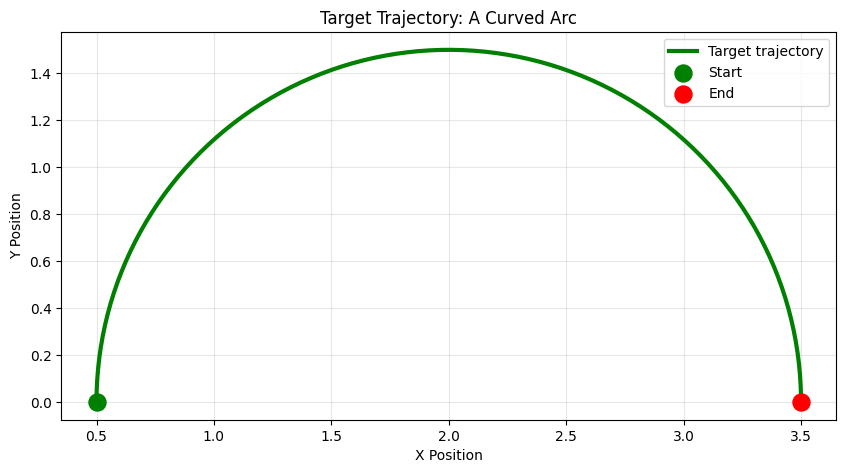

Target trajectory: 200 points
Start: (0.50, -0.00)
End: (3.50, 0.00)


In [2]:
#### Let's set up a simple target trajectory
config = SimulationConfig(dt=0.01, num_steps=200, bounds=((-5, 5), (-5, 5)))

# Initial state: ball starts at origin moving right
initial_state = PhysicsState.create(position=(0.0, 0.0), velocity=(1.5, 0.0))

# Target: a curved arc trajectory
target_trajectory = generate_arc_trajectory(
    center=(2.0, 0.0),
    radius=1.5,
    start_angle=jnp.pi,  # Start from left of center
    end_angle=0,          # End at right of center
    num_points=config.num_steps
)

# Visualize the target
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'g-', linewidth=3, label='Target trajectory')
ax.scatter([target_trajectory[0, 0]], [target_trajectory[0, 1]], c='green', s=150, zorder=5, label='Start')
ax.scatter([target_trajectory[-1, 0]], [target_trajectory[-1, 1]], c='red', s=150, zorder=5, label='End')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Target Trajectory: A Curved Arc')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.show()

print(f"Target trajectory: {len(target_trajectory)} points")
print(f"Start: ({target_trajectory[0, 0]:.2f}, {target_trajectory[0, 1]:.2f})")
print(f"End: ({target_trajectory[-1, 0]:.2f}, {target_trajectory[-1, 1]:.2f})")


## Part 2: Loss Functions

To optimize, we need to measure how close our simulated trajectory is to the target. Common choices:

1. **L2 Loss**: $\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N} \|\tau_i - \tau^*_i\|^2$
2. **Endpoint Loss**: $\mathcal{L} = \|\tau_N - \tau^*_N\|^2$
3. **Waypoint Loss**: Match specific points at specific times


In [3]:
# Create a loss function for wind field optimization
loss_fn = make_trajectory_loss_fn(
    initial_state=initial_state,
    target_trajectory=target_trajectory,
    config=config,
    field_type='wind',
)

# Test with different wind parameters
test_params = [
    create_wind_params(center=(1.5, 0.5), direction=(0, 1), strength=0),
    create_wind_params(center=(1.5, 0.5), direction=(0, 1), strength=5),
    create_wind_params(center=(1.5, 0.5), direction=(0, 1), strength=10),
    create_wind_params(center=(1.5, 0.5), direction=(0, 1), strength=15),
]

print("Testing different wind strengths:")
print("-" * 40)
for params in test_params:
    loss = loss_fn(params)
    print(f"Strength {params['strength']:5.1f} → Loss: {loss:.4f}")


Testing different wind strengths:
----------------------------------------
Strength   0.0 → Loss: 1.4295
Strength   5.0 → Loss: 3.9169
Strength  10.0 → Loss: 5.0572
Strength  15.0 → Loss: 3.9140


## Part 3: Gradient Descent Optimization

Now let's use gradient descent to find the optimal wind field!


In [4]:
# Manual gradient descent to see what's happening
initial_params = create_wind_params(
    center=(1.5, 0.5),
    size=(2.5, 3.0),
    direction=(0.0, 1.0),
    strength=1.0,  # Start with weak wind
)

# Get gradient function
grad_fn = grad(loss_fn)

# Run gradient descent manually
params = initial_params.copy()
learning_rate = 0.05
history = {'loss': [], 'strength': [], 'center_x': [], 'center_y': []}

print("Running gradient descent...")
print("-" * 50)

for i in range(100):
    loss = loss_fn(params)
    grads = grad_fn(params)
    
    history['loss'].append(float(loss))
    history['strength'].append(float(params['strength']))
    history['center_x'].append(float(params['center'][0]))
    history['center_y'].append(float(params['center'][1]))
    
    # Update parameters
    params = {k: v - learning_rate * grads[k] for k, v in params.items()}
    
    if i % 20 == 0:
        print(f"Iter {i:3d}: loss={loss:.4f}, strength={params['strength']:.2f}, "
              f"center=({params['center'][0]:.2f}, {params['center'][1]:.2f})")

print(f"\nFinal: loss={history['loss'][-1]:.4f}, strength={params['strength']:.2f}")


Running gradient descent...
--------------------------------------------------
Iter   0: loss=1.1014, strength=0.99, center=(1.49, 0.50)
Iter  20: loss=0.7981, strength=0.98, center=(1.28, 0.50)
Iter  40: loss=0.7447, strength=1.02, center=(1.13, 0.50)
Iter  60: loss=0.7303, strength=1.05, center=(1.02, 0.50)
Iter  80: loss=0.7201, strength=1.06, center=(0.92, 0.50)

Final: loss=0.7109, strength=1.09


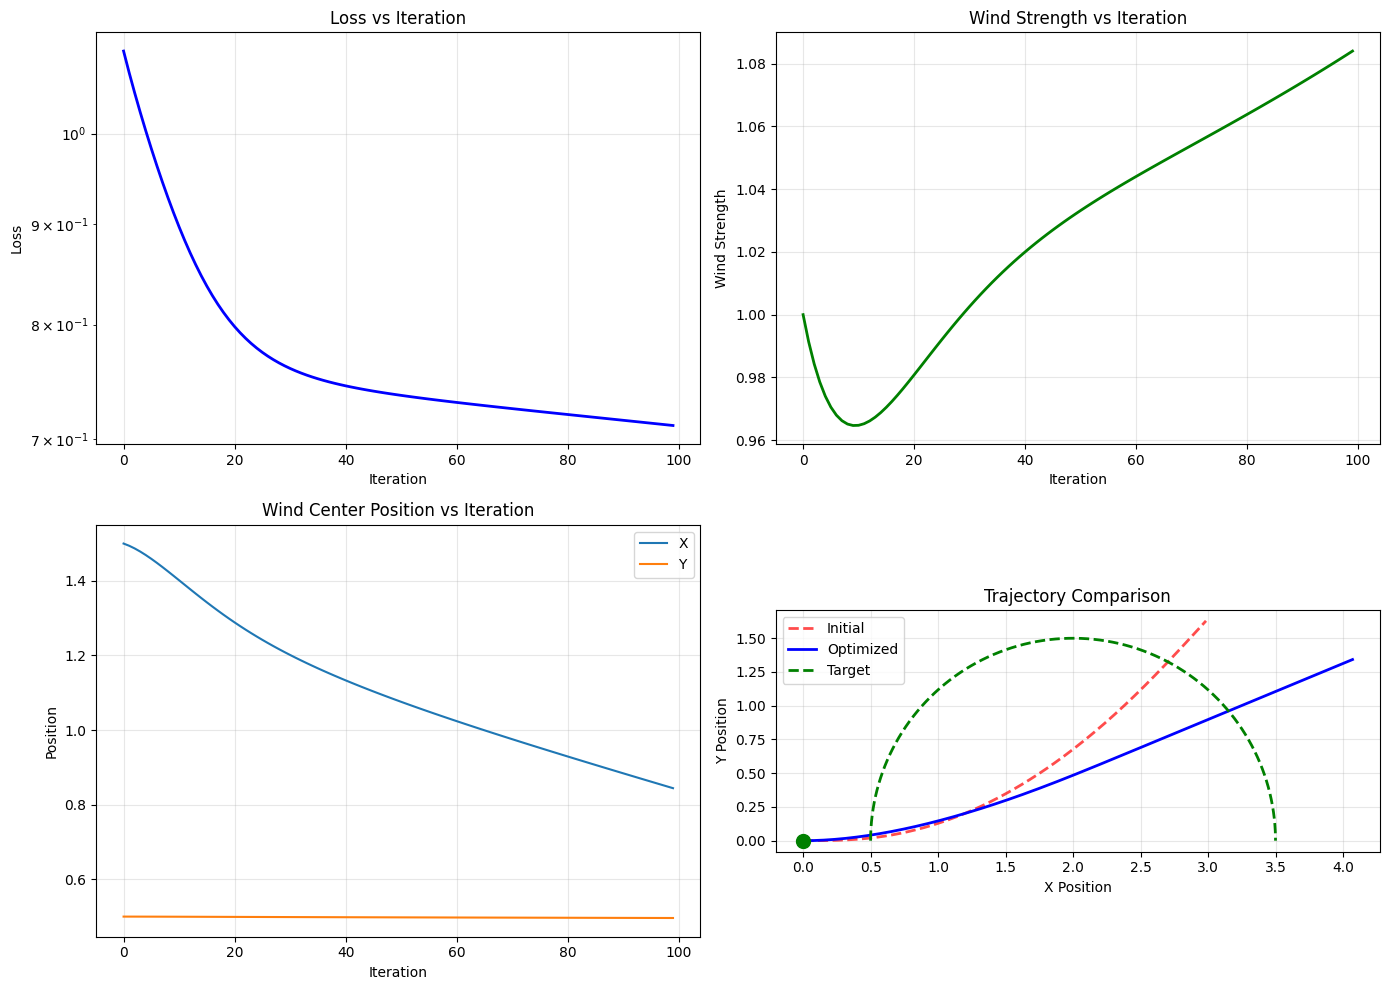

In [5]:
# Visualize optimization progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
ax = axes[0, 0]
ax.plot(history['loss'], 'b-', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iteration')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Strength evolution
ax = axes[0, 1]
ax.plot(history['strength'], 'g-', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Wind Strength')
ax.set_title('Wind Strength vs Iteration')
ax.grid(True, alpha=0.3)

# Center position evolution
ax = axes[1, 0]
ax.plot(history['center_x'], label='X')
ax.plot(history['center_y'], label='Y')
ax.set_xlabel('Iteration')
ax.set_ylabel('Position')
ax.set_title('Wind Center Position vs Iteration')
ax.legend()
ax.grid(True, alpha=0.3)

# Trajectory comparison
ax = axes[1, 1]
# Initial trajectory
initial_field = params_to_wind_field(initial_params)
initial_traj = simulate_positions_only(initial_state, [initial_field], config)
ax.plot(initial_traj[:, 0], initial_traj[:, 1], 'r--', linewidth=2, label='Initial', alpha=0.7)

# Optimized trajectory
optimized_field = params_to_wind_field(params)
optimized_traj = simulate_positions_only(initial_state, [optimized_field], config)
ax.plot(optimized_traj[:, 0], optimized_traj[:, 1], 'b-', linewidth=2, label='Optimized')

# Target
ax.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'g--', linewidth=2, label='Target')
ax.scatter([0], [0], c='green', s=100, zorder=5)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Trajectory Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


## Part 4: Using the High-Level Optimizer

Our `physics.optimization` module provides convenient functions for optimization.


In [6]:
# Use the high-level optimizer with Adam
optimal_field, result = find_optimal_wind(
    initial_state=initial_state,
    target_trajectory=target_trajectory,
    config=config,
    optimizer='adam',
    num_iterations=150,
    learning_rate=0.05,
    verbose=True,
)

print(f"\n✅ Optimization complete!")
print(f"Final loss: {result.final_loss:.6f}")
print(f"Converged: {result.converged}")
print(f"Iterations: {result.num_iterations}")


Optimizing (Adam): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 350.00it/s, loss=1.0163]



✅ Optimization complete!
Final loss: 0.871180
Converged: False
Iterations: 150


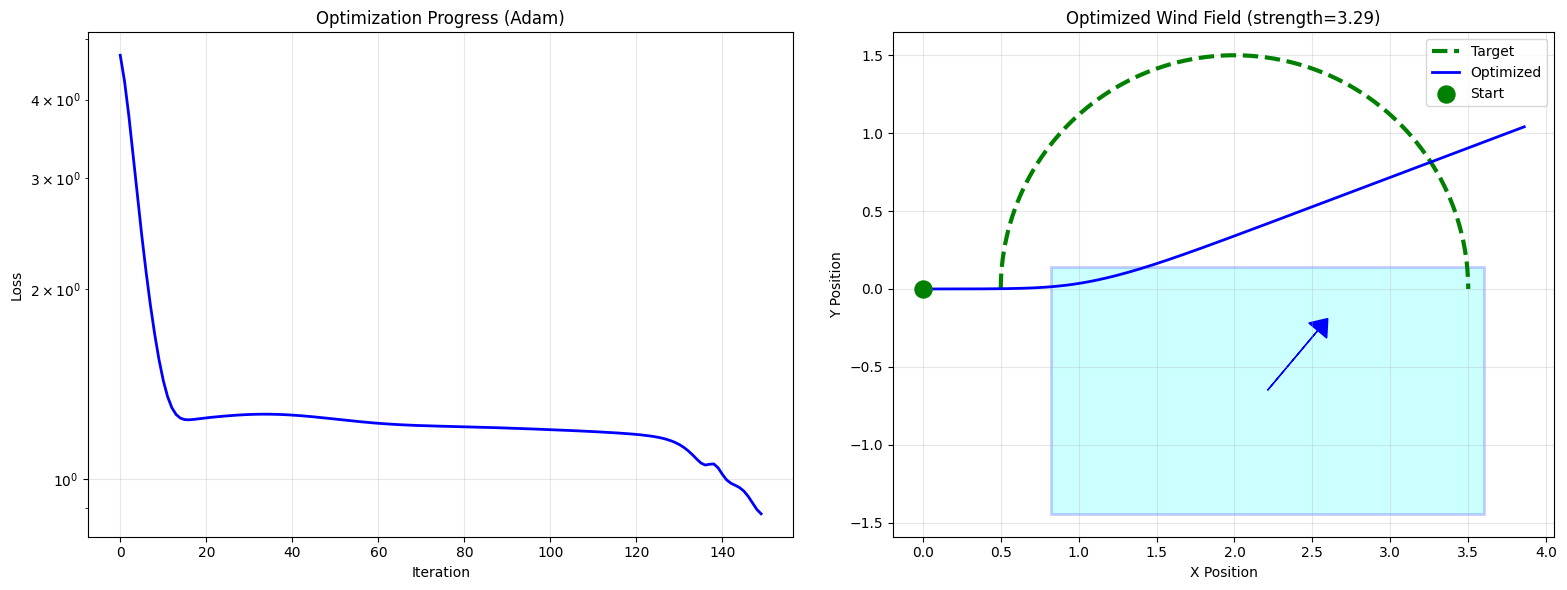


Optimal wind field parameters:
  Center: (2.21, -0.65)
  Size: (2.78, 1.59)
  Direction: (0.64, 0.77)
  Strength: 3.29


In [7]:
# Visualize the result
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax = axes[0]
ax.plot(result.history['losses'], 'b-', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Optimization Progress (Adam)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Trajectory comparison
ax = axes[1]
optimized_traj = simulate_positions_only(initial_state, [optimal_field], config)

ax.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'g--', linewidth=3, label='Target')
ax.plot(optimized_traj[:, 0], optimized_traj[:, 1], 'b-', linewidth=2, label='Optimized')

# Draw wind field
rect = Rectangle(
    optimal_field.center - optimal_field.size/2, 
    optimal_field.size[0], optimal_field.size[1],
    fill=True, facecolor='cyan', alpha=0.2, edgecolor='blue', linewidth=2
)
ax.add_patch(rect)
ax.arrow(float(optimal_field.center[0]), float(optimal_field.center[1]), 
         float(optimal_field.direction[0])*0.5, float(optimal_field.direction[1])*0.5,
         head_width=0.15, head_length=0.1, fc='blue', ec='blue')

ax.scatter([0], [0], c='green', s=150, zorder=5, label='Start')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title(f'Optimized Wind Field (strength={optimal_field.strength:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nOptimal wind field parameters:")
print(f"  Center: ({optimal_field.center[0]:.2f}, {optimal_field.center[1]:.2f})")
print(f"  Size: ({optimal_field.size[0]:.2f}, {optimal_field.size[1]:.2f})")
print(f"  Direction: ({optimal_field.direction[0]:.2f}, {optimal_field.direction[1]:.2f})")
print(f"  Strength: {optimal_field.strength:.2f}")


## Part 5: Visualizing the Loss Landscape

Let's explore how the loss varies with different parameters to understand the optimization landscape.


Computing loss landscape...


  0%|          | 0/30 [00:00<?, ?it/s]

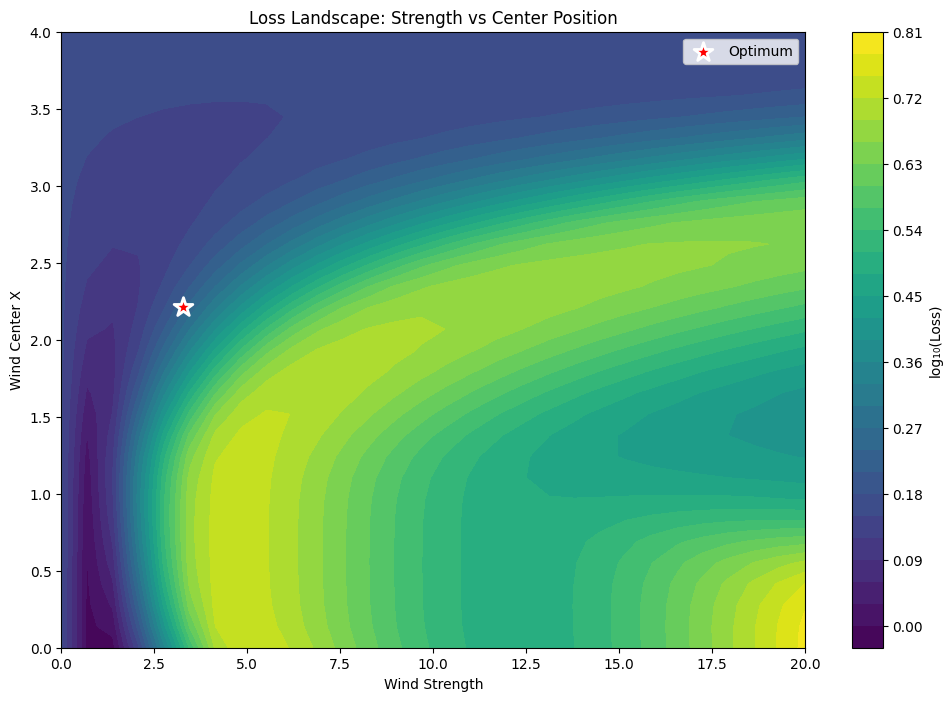

In [8]:
# Compute loss landscape for wind strength and center_x
strengths = np.linspace(0, 20, 30)
center_xs = np.linspace(0, 4, 30)

losses = np.zeros((len(center_xs), len(strengths)))

print("Computing loss landscape...")
for i, cx in enumerate(tqdm(center_xs)):
    for j, s in enumerate(strengths):
        params = create_wind_params(
            center=(cx, 0.5),
            size=(2.5, 3.0),
            direction=(0.0, 1.0),
            strength=s,
        )
        losses[i, j] = float(loss_fn(params))

# Plot loss landscape
fig, ax = plt.subplots(figsize=(12, 8))
X, Y = np.meshgrid(strengths, center_xs)
im = ax.contourf(X, Y, np.log10(losses + 1e-6), levels=30, cmap='viridis')
plt.colorbar(im, ax=ax, label='log₁₀(Loss)')

# Mark the optimum
opt_strength = float(optimal_field.strength)
opt_cx = float(optimal_field.center[0])
ax.scatter([opt_strength], [opt_cx], c='red', s=200, marker='*', 
           edgecolors='white', linewidths=2, zorder=5, label='Optimum')

ax.set_xlabel('Wind Strength')
ax.set_ylabel('Wind Center X')
ax.set_title('Loss Landscape: Strength vs Center Position')
ax.legend()
plt.show()


## Part 6: More Complex Trajectories

Let's try optimizing for more challenging target trajectories.


In [9]:
# Try a sine wave trajectory
config2 = SimulationConfig(dt=0.01, num_steps=300, bounds=((-5, 5), (-5, 5)))
initial_state2 = PhysicsState.create(position=(0.0, 0.0), velocity=(1.2, 0.0))

sine_target = generate_sine_wave_trajectory(
    start=(0.0, 0.0),
    end=(4.0, 0.0),
    amplitude=1.0,
    frequency=1.5,
    num_points=config2.num_steps
)

# Optimize with a vortex field (better for wavy paths)
optimal_vortex, result_vortex = find_optimal_vortex(
    initial_state=initial_state2,
    target_trajectory=sine_target,
    config=config2,
    optimizer='adam',
    num_iterations=200,
    learning_rate=0.03,
    verbose=True,
)

print(f"\n✅ Vortex optimization complete!")
print(f"Final loss: {result_vortex.final_loss:.6f}")


Optimizing (Adam): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.96it/s, loss=0.5558]



✅ Vortex optimization complete!
Final loss: 0.555678


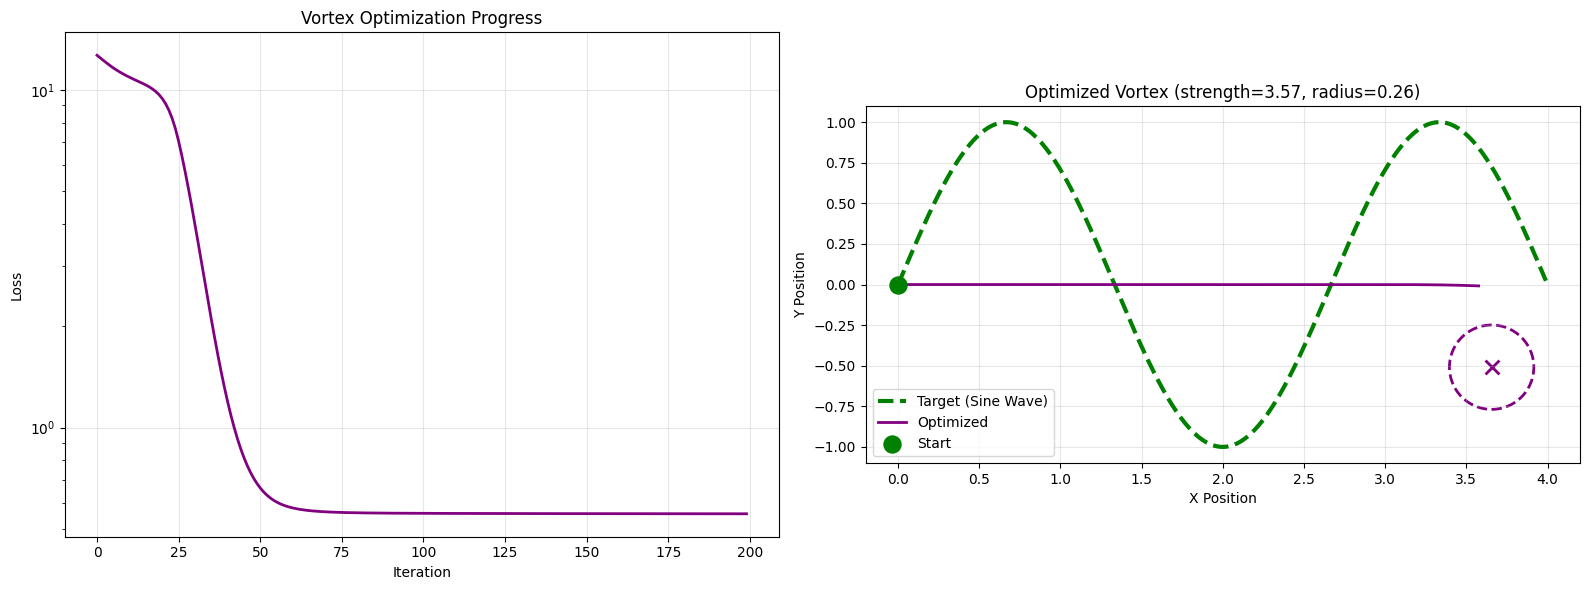

In [10]:
# Visualize the vortex optimization result
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax = axes[0]
ax.plot(result_vortex.history['losses'], 'purple', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Vortex Optimization Progress')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Trajectory comparison
ax = axes[1]
vortex_traj = simulate_positions_only(initial_state2, [optimal_vortex], config2)

ax.plot(sine_target[:, 0], sine_target[:, 1], 'g--', linewidth=3, label='Target (Sine Wave)')
ax.plot(vortex_traj[:, 0], vortex_traj[:, 1], 'purple', linewidth=2, label='Optimized')

# Draw vortex
circle = Circle(optimal_vortex.center, optimal_vortex.radius, 
                fill=False, color='purple', linewidth=2, linestyle='--')
ax.add_patch(circle)
ax.scatter([float(optimal_vortex.center[0])], [float(optimal_vortex.center[1])], 
           c='purple', s=100, marker='x', linewidths=2)

ax.scatter([0], [0], c='green', s=150, zorder=5, label='Start')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title(f'Optimized Vortex (strength={optimal_vortex.strength:.2f}, radius={optimal_vortex.radius:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


## Summary

In this notebook, we learned:

1. **The Inverse Problem**: Finding force fields from trajectories is hard!
2. **Loss Functions**: L2 loss measures trajectory matching quality
3. **Gradient Descent**: Iteratively improve parameters using gradients
4. **Adam Optimizer**: Often faster convergence than vanilla gradient descent
5. **Loss Landscape**: Visualizing helps understand optimization difficulty

## Key Challenges

- **Local Minima**: Optimization may get stuck in suboptimal solutions
- **Sensitivity**: Small parameter changes can cause large trajectory changes
- **Multiple Solutions**: Different field configurations can produce similar trajectories
- **Expressiveness**: A single field type may not be able to produce complex paths

## Next Steps

In the next notebook, we'll train a **neural network** to predict force field configurations directly from target trajectories - amortizing the optimization cost!

See you in **04_learning_the_inverse.ipynb**! 🚀
